# **Flipkart Classification Project**    -

## **Github** -

### **Problem Statement and Description**    -

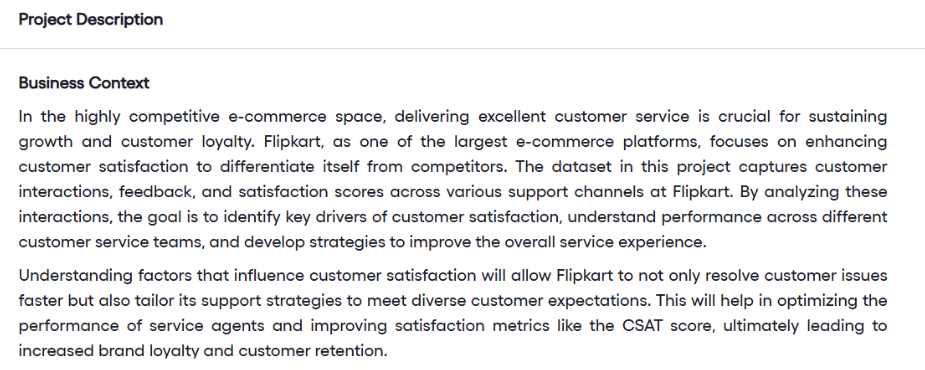

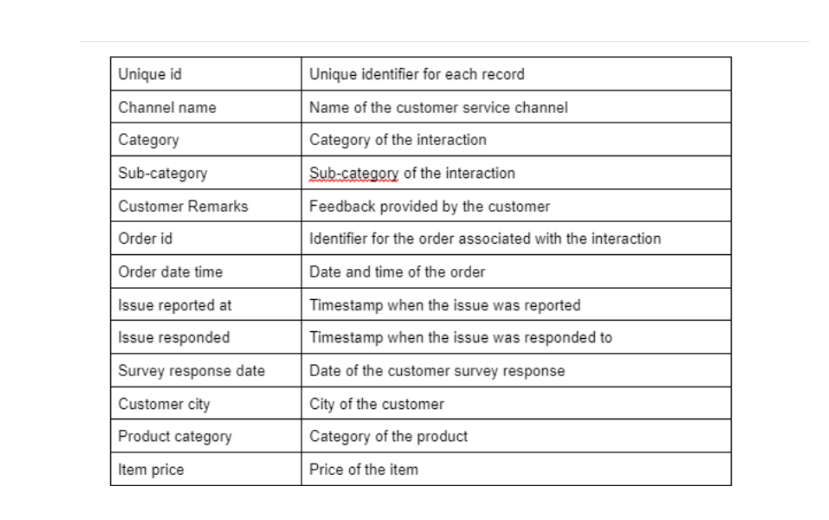

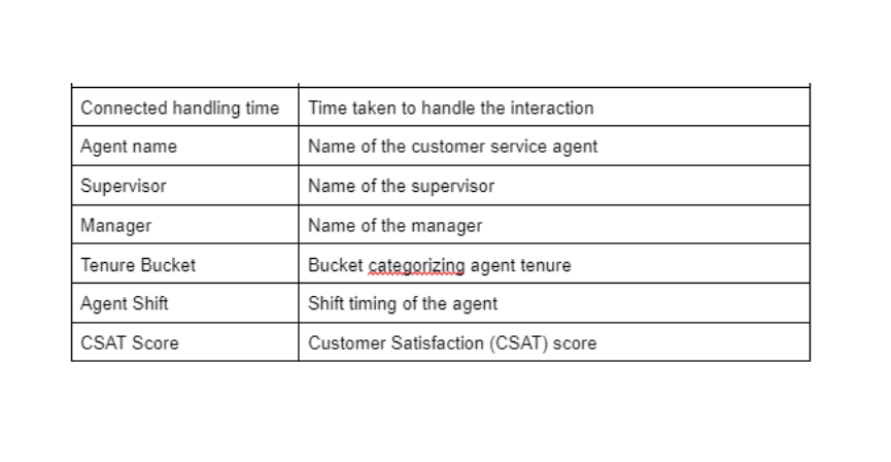

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgbm
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, fbeta_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [35]:
file_data = '/content/Customer_support_data.csv'
df_data = pd.read_csv(file_data)

In [36]:
df_data.shape


(85907, 20)

In [37]:
df_data.columns

Index(['Unique id', 'channel_name', 'category', 'Sub-category',
       'Customer Remarks', 'Order_id', 'order_date_time', 'Issue_reported at',
       'issue_responded', 'Survey_response_Date', 'Customer_City',
       'Product_category', 'Item_price', 'connected_handling_time',
       'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift',
       'CSAT Score'],
      dtype='object')

In [38]:
len(df_data.columns)

20

In [39]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14  Agent_name            

In [40]:
df_data.describe()

,Item_price,connected_handling_time,CSAT Score
count,17206.000000,242.000000,85907.000000
mean,5660.774846,462.400826,4.242157
std,12825.728411,246.295037,1.378903
min,0.000000,0.000000,1.000000
25%,392.000000,293.000000,4.000000
50%,979.000000,427.000000,5.000000
75%,2699.750000,592.250000,5.000000
max,164999.000000,1986.000000,5.000000


In [41]:
def missing_values_summary(df_data: pd.DataFrame) -> pd.Series:
    """
    Returns the number of missing values per column in descending order.

    Parameters:
        df (pd.DataFrame): Input dataframe.

    Returns:
        pd.Series: Series with column names as index and missing counts as values.
    """
    missing_counts = df_data.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]  # keep only columns with missing values
    return missing_counts.sort_values(ascending=False)


In [42]:
missing_values_summary(df_data)

,0
connected_handling_time,85665
Customer_City,68828
Product_category,68711
Item_price,68701
order_date_time,68693
Customer Remarks,57165
Order_id,18232


Eliminating columns that have high missing values and unlikely to contribute to CSAT score

In [43]:
df_data.drop(['Unique id', 'Order_id', 'order_date_time', 'Survey_response_Date', 'connected_handling_time', 'Customer_City', 'Product_category', 'Item_price'], axis=1, inplace=True)
df_data.head(10)

,channel_name,category,Sub-category,Customer Remarks,Issue_reported at,issue_responded,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,Outcall,Product Queries,Life Insurance,NaN,01/08/2023 11:13,01/08/2023 11:47,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,Outcall,Product Queries,Product Specific Information,NaN,01/08/2023 12:52,01/08/2023 12:54,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,Inbound,Order Related,Installation/demo,NaN,01/08/2023 20:16,01/08/2023 20:38,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,Inbound,Returns,Reverse Pickup Enquiry,NaN,01/08/2023 20:56,01/08/2023 21:16,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,Inbound,Cancellation,Not Needed,NaN,01/08/2023 10:30,01/08/2023 10:32,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5
5,Email,Returns,Fraudulent User,NaN,01/08/2023 15:13,01/08/2023 18:39,Desiree Newton,Emma Park,John Smith,0-30,Morning,5
6,Outcall,Product Queries,Product Specific Information,NaN,01/08/2023 15:31,01/08/2023 23:52,Shannon Hicks,Aiden Patel,Olivia Tan,>90,Morning,5
7,Inbound,Returns,Exchange / Replacement,Very good,01/08/2023 16:17,01/08/2023 16:23,Laura Smith,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening,5
8,Inbound,Returns,Missing,Shopzilla app and it's all coustomer care serv...,01/08/2023 21:03,01/08/2023 21:07,David Smith,Nathan Patel,John Smith,>90,Split,5
9,Inbound,Shopzilla Related,General Enquiry,NaN,01/08/2023 23:31,01/08/2023 23:36,Tabitha Ayala,Amelia Tanaka,Michael Lee,31-60,Evening,5


In [44]:
len(df_data.columns)

12

In [45]:
df_data.columns

Index(['channel_name', 'category', 'Sub-category', 'Customer Remarks',
       'Issue_reported at', 'issue_responded', 'Agent_name', 'Supervisor',
       'Manager', 'Tenure Bucket', 'Agent Shift', 'CSAT Score'],
      dtype='object')

In [46]:
duplicates = df_data.duplicated().sum().tolist()
duplicates

9

In [47]:
df_data[df_data.duplicated()]

,channel_name,category,Sub-category,Customer Remarks,Issue_reported at,issue_responded,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
9242,Inbound,Order Related,Installation/demo,NaN,04/08/2023 09:54,04/08/2023 10:00,Kathryn Vasquez,Noah Patel,Michael Lee,>90,Morning,5
12002,Inbound,Returns,Reverse Pickup Enquiry,NaN,05/08/2023 09:15,05/08/2023 09:26,Anthony Booth,William Park,John Smith,31-60,Morning,5
16899,Inbound,Payments related,e-Gift Voucher,NaN,07/08/2023 22:05,07/08/2023 22:23,Lee Allen PhD,Elijah Yamaguchi,John Smith,>90,Evening,5
53253,Outcall,Payments related,Payment related Queries,NaN,20/08/2023 10:21,20/08/2023 10:26,Randy May,Emily Yamashita,William Kim,On Job Training,Evening,5
58444,Outcall,Shopzilla Related,Shopzila Premium Related,NaN,22/08/2023 21:14,22/08/2023 21:17,Rebecca Walker,Logan Lee,Emily Chen,61-90,Evening,5
61792,Email,Returns,Reverse Pickup Enquiry,NaN,23/08/2023 10:56,23/08/2023 10:57,Joe Chapman,Sophia Chen,Jennifer Nguyen,On Job Training,Evening,5
77516,Email,Order Related,Unable to track,NaN,28/08/2023 18:30,28/08/2023 00:00,Mrs. Jennifer Stone,Dylan Kim,Michael Lee,>90,Morning,1
79734,Email,Returns,Reverse Pickup Enquiry,NaN,28/08/2023 12:30,29/08/2023 10:18,Janet Shea,Emma Park,Olivia Tan,>90,Morning,4
85501,Email,Order Related,Delayed,NaN,30/08/2023 11:03,31/08/2023 21:59,Jose Pruitt,Zoe Yamamoto,William Kim,On Job Training,Morning,1


In [48]:
df_data.shape

(85907, 12)

In [49]:
df_data=df_data.drop_duplicates().reset_index(drop=True)

In [50]:
df_data.shape

(85898, 12)

In [51]:
df_data.nunique()

,0
channel_name,3
category,12
Sub-category,57
Customer Remarks,18231
Issue_reported at,30923
issue_responded,30262
Agent_name,1371
Supervisor,40
Manager,6
Tenure Bucket,5


Creating lists of numerical and categorical columns

In [52]:
num_cols = df_data.select_dtypes(include=['number']).columns.tolist()
cat_cols = df_data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numerical features : ", num_cols)
print("Categorical features : ", cat_cols)

Numerical features :  ['CSAT Score']
Categorical features :  ['channel_name', 'category', 'Sub-category', 'Customer Remarks', 'Issue_reported at', 'issue_responded', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift']


Plotting CSAT Score

<Axes: xlabel='CSAT Score', ylabel='Count'>

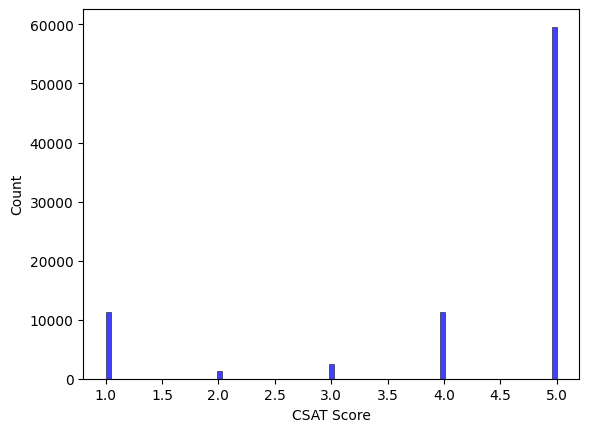

In [53]:
sns.histplot(x='CSAT Score', color='blue', data=df_data)

In [58]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [90]:
def classify_sentiments(df: pd.DataFrame, text_col: str) -> pd.DataFrame:

    sia = SentimentIntensityAnalyzer()

    def get_sentiment(text):
        if pd.isnull(text) or str(text).strip() == "":
            return "Missing"
        score = sia.polarity_scores(str(text))["compound"]
        if score >= 0.05:
            return "Positive"
        elif score <= -0.05:
            return "Negative"
        else:
            return "Neutral"  # keep neutral separate (optional)

    # create a copy so original df isn’t modified
    new_df = df.copy()
    new_df["Sentiment"] = new_df[text_col].apply(get_sentiment)
    return new_df

In [92]:
df_data = classify_sentiments(df_data, "Customer Remarks")
df_data

,channel_name,category,Sub-category,Customer Remarks,Issue_reported at,issue_responded,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score,Sentiment
0,Outcall,Product Queries,Life Insurance,NaN,01/08/2023 11:13,01/08/2023 11:47,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,Missing
1,Outcall,Product Queries,Product Specific Information,NaN,01/08/2023 12:52,01/08/2023 12:54,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,Missing
2,Inbound,Order Related,Installation/demo,NaN,01/08/2023 20:16,01/08/2023 20:38,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,Missing
3,Inbound,Returns,Reverse Pickup Enquiry,NaN,01/08/2023 20:56,01/08/2023 21:16,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,Missing
4,Inbound,Cancellation,Not Needed,NaN,01/08/2023 10:30,01/08/2023 10:32,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85893,Inbound,Refund Related,Refund Enquiry,NaN,30/08/2023 23:20,31/08/2023 07:22,Brandon Leon,Ethan Tan,William Kim,On Job Training,Morning,4,Missing
85894,Inbound,Order Related,Seller Cancelled Order,Supported team customer executive good,31/08/2023 08:15,31/08/2023 08:17,Linda Foster,Noah Patel,Emily Chen,>90,Morning,5,Positive
85895,Inbound,Order Related,Order status enquiry,need to improve with proper details.,31/08/2023 18:57,31/08/2023 19:02,Kimberly Martinez,Aiden Patel,Olivia Tan,On Job Training,Evening,5,Positive
85896,Inbound,Feedback,UnProfessional Behaviour,NaN,31/08/2023 19:59,31/08/2023 20:00,Daniel Martin,Olivia Suzuki,Olivia Tan,>90,Morning,4,Missing


In [93]:
df_data[['Sentiment', 'Customer Remarks']][:100]

,Sentiment,Customer Remarks
0,Missing,NaN
1,Missing,NaN
2,Missing,NaN
3,Missing,NaN
4,Missing,NaN
...,...,...
95,Positive,Please pack the products which actually custom...
96,Missing,NaN
97,Missing,NaN
98,Positive,Thanks


In [94]:
df_data_new = df_data.drop(['Customer Remarks'], axis=1)
df_data_new.head(5)

,channel_name,category,Sub-category,Issue_reported at,issue_responded,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score,Sentiment
0,Outcall,Product Queries,Life Insurance,01/08/2023 11:13,01/08/2023 11:47,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,Missing
1,Outcall,Product Queries,Product Specific Information,01/08/2023 12:52,01/08/2023 12:54,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,Missing
2,Inbound,Order Related,Installation/demo,01/08/2023 20:16,01/08/2023 20:38,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,Missing
3,Inbound,Returns,Reverse Pickup Enquiry,01/08/2023 20:56,01/08/2023 21:16,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,Missing
4,Inbound,Cancellation,Not Needed,01/08/2023 10:30,01/08/2023 10:32,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,Missing


In [99]:
df_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85898 entries, 0 to 85897
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   channel_name       85898 non-null  object
 1   category           85898 non-null  object
 2   Sub-category       85898 non-null  object
 3   Issue_reported at  85898 non-null  object
 4   issue_responded    85898 non-null  object
 5   Agent_name         85898 non-null  object
 6   Supervisor         85898 non-null  object
 7   Manager            85898 non-null  object
 8   Tenure Bucket      85898 non-null  object
 9   Agent Shift        85898 non-null  object
 10  CSAT Score         85898 non-null  int64 
 11  Sentiment          85898 non-null  object
dtypes: int64(1), object(11)
memory usage: 7.9+ MB


Train Test Split and Resampling

In [95]:
X = df_data_new.drop('CSAT Score', axis=1)
y = df_data_new['CSAT Score']

In [96]:
X.shape

(85898, 11)

In [97]:
y.shape

(85898,)